### How does PDE dynamics change with synthetic timesteps?

In [1]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

# with h5py.File(f'data_large/Burgers_train_100000_default.h5', 'r') as f:
#     # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
#     traj = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
import hydra
from omegaconf import DictConfig, OmegaConf
from generate_data import evolve
from tqdm import tqdm

class Traj_dataset:
    traj_train = None
    traj_valid = None
    traj_test = None

def mean_std_normalize():
    assert Traj_dataset.traj_train is not None
    mean = Traj_dataset.traj_train[:32].mean()
    std = Traj_dataset.traj_train[:32].std()
    print(f'Mean: {mean}, Std: {std}')
    Traj_dataset.mean = mean
    Traj_dataset.std = std

def mean_std_normalize():
    assert Traj_dataset.traj_train is not None
    mean = Traj_dataset.traj_train[:32].mean()
    std = Traj_dataset.traj_train[:32].std()
    print(f'Mean: {mean}, Std: {std}')
    Traj_dataset.mean = mean
    Traj_dataset.std = std

# def max_min_normalize():
#     assert Traj_dataset.traj_train is not None
#     max_val = Traj_dataset.traj_train[:32].max()
#     min_val = Traj_dataset.traj_train[:32].min()
#     mean = (max_val + min_val) / 2
#     std = (max_val - min_val) / 2
#     print(f'Max: {max_val}, Min: {min_val}')
#     Traj_dataset.mean = mean
#     Traj_dataset.std = std


hydra.initialize(config_path="cfg_flexible", version_base=None)
cfg = hydra.compose(config_name="config", overrides=["task=Burgers", "nt=14"])

timestep = (131 - 1) // (cfg.nt - 1) # 10

print('Loading training data...')
with h5py.File(cfg.dataset.train_path, 'r') as f:
    Traj_dataset.traj_train = torch.tensor(f['train']['pde'][:cfg.datasize, :131:timestep], dtype=torch.float32)
print('Loading test data...')
with h5py.File(cfg.dataset.test_path, 'r') as f:
    Traj_dataset.traj_test = torch.tensor(f['test']['pde'][:cfg.testsize, :131:timestep], dtype=torch.float32)

# print(Traj_dataset.traj_train.mean(dim=-1))

    # mean_std_normalize()

Loading training data...
Loading test data...


Text(0.5, 1.0, 'Example trajectory of Burgers')

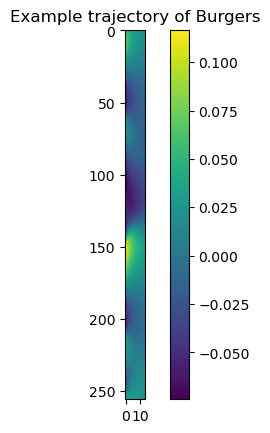

In [3]:
plt.figure()
plt.imshow(Traj_dataset.traj_train[0,:,0].cpu().numpy().T)
plt.colorbar()
plt.title(f'Example trajectory of {cfg.equation}')

In [4]:
u0=Traj_dataset.traj_train[0:1,0]
u = [u0]
for t in range(1,cfg.nt):
    u.append(evolve(u[-1], cfg)[:,0])
u = torch.cat(u, dim=0)
print(u.shape)


torch.Size([14, 1, 256])


Text(0.5, 1.0, 'Example trajectory of Burgers')

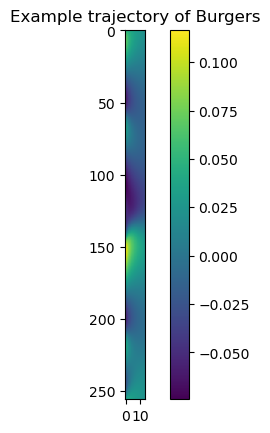

In [5]:
plt.figure()
plt.imshow(u[:,0].cpu().numpy().T)
plt.colorbar()
plt.title(f'Example trajectory of {cfg.equation}')

Robustness to mean shift

In [6]:
u0=Traj_dataset.traj_train[0:1,0]
u = [u0+0.1]
for t in range(1,cfg.nt):
    u.append(evolve(u[-1], cfg)[:,0])
u = torch.cat(u, dim=0)
print(u.shape)


torch.Size([14, 1, 256])


Text(0.5, 1.0, 'Example trajectory of Burgers')

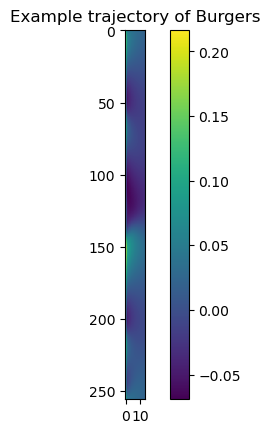

In [7]:
plt.figure()
plt.imshow(u[:,0].cpu().numpy().T)
plt.colorbar()
plt.title(f'Example trajectory of {cfg.equation}')

In [8]:
(u[:,0] - Traj_dataset.traj_train[0,:,0]).norm(dim=1) / Traj_dataset.traj_train[0,:,0].norm(dim=1)

tensor([2.0051e+00, 1.6838e-05, 1.5513e-05, 3.7001e-05, 2.5388e-05, 1.6320e-05,
        1.4429e-05, 2.0354e-05, 3.1310e-05, 1.3937e-05, 4.1699e-05, 1.7003e-05,
        1.9597e-05, 1.9570e-05])

Is it correct for all 4096 trajectories?

In [10]:
u0=Traj_dataset.traj_train[0:4096,0]
u = [u0]
u = evolve(u0, cfg, timesteps=13)
# for t in range(1,cfg.nt):
#     u.append(evolve(u[-1], cfg)[:,0])
# u = torch.cat(u, dim=0)
print(u.shape)


/mnt/home/yegonkim/home/lupi/generate_data.py:593: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).to(device)


torch.Size([4096, 13, 1, 256])


In [ ]:
(u[:,0] - Traj_dataset.traj_train[0,:,0]).norm(dim=1) / Traj_dataset.traj_train[0,:,0].norm(dim=1)